<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. Sort the alarms into 'Errors' and 'Valid'. i.e. Alarm Duration < PAAP & Cycle Time is a Valid Scenario. Errors are EITHER Alarm Duration > PAAP OR Alarm Duration > PAAP & Cycle Time
    Have decided to take the subset of Duration < Cycle Time as GT's that make feasible sense.
10. Carry out More detailed analysis to gauge size of the prize. Here we have taken the 95th percentile of cycle times to remove outlier GT's. We had already previously removed Trial Recipes. Then:
    •	Analyse if they have taken each alarm once or twice. Need to sort by Null i.e. (Mahesh is handling)
    •	Count of 'Valid' Alarms. Calculate percentage out of all GT's Produced 
    •	Recalculate time saving per cycle time for start_time and ProducedOn Time. i.e. Redo Allocation of GT's
    •	See Date dependence of PA alarms. (one day may be particularly bad due to converyor belt issue, or Recipe   inherent etc.) (Automation Conveyor may have an issue on one particylar day). See if Date Dependent
11. Continuation of 10, to carry out more detailed analysis to gauge size of the prize
    •	See correlation coeff with Duration and Cycle time/PAAP time
    •	General Analysis of PAAP Times
    •	Check next and previous tyres for the Errors.   
    •	Investigate for other TBM's
12.	Plot these comparisons and highlight your observations. Add any other analysis as we go along: 
    •	Total CT variation - m/c wise
    •	CT variation - application wise
    •	Total CT variation - Diameter wise
    •	Total CT variation - Recipe wise
    •	Number of changeovers - m/c wise 
    •	Number of changeovers - due to recipe, due to diameter
13. PREASSEMBLY LENGTH NOT CORRECT Alarm investigation. Alarm Duration Distribution, as this alarms Duration IS linked to Machine Stoppage Time. GT allocation, and Alarm duration vs PAAP time check. All seems okay, as vast majority are Scenario 1.
    • Scenario 1 : Alarm Duration < PAAP Times
    • Scenario 2 : Alarm Duration > PAAP Times 
    • Scenario 3 : Alarm Duration > PAAP Times & Cycle Time
14. Plot Probablity Density of 3 Scenarios, KDE Distribution of Cycle Times (not filtered by SKU), and cycle time percentiles. Compare GT's before and after Outlier removal at 85th percentile, and investigate effect on PAAP time. Conculsion was:
    Projected reduction in average Cycle Time If Alarm was non-existent: 0.683s
    Projected reduction in average PAAP Time If Alarm was non-existent: 0.499s
15. 14 workflow but for PAAP length out of tolerance
16. Take the GT's which were Scenario 1, and the Cycle times for all other steps (not just PAAP) and calculate z-scores for each column for each GT. This way, we can eliminate GT's which had outlier times in any other step than PAAP i.e. Remove GT's which had unusual steps other than PAAP. Plot Cycle Time of PREASSEMBLY LENGTH NOT CORRECT GT's after removal of non-PAAP step Outliers. Validate that longer cycle times were due to PAAP. 

In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
TBM = TBM()
p = bcolors()
FS = Feature_Selection()
DF = Data_Functions()

In [5]:
df_PA_tbm_join_Alarm = pd.read_pickle('./pkl/PA_Alarms_joined_with_tbm_data_alarm_2.pkl')
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")

1. Scenario 1 : Alarm Duration < PAAP Times
2. Scenario 2 : Alarm Duration > PAAP Times 
3. Scenario 3 : Alarm Duration > PAAP Times & Cycle Time

In [6]:
scen1 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] < df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.gv('no. Scenario 1 Alarms:', len(scen1))
scen2 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.gv('no. Scenario 2 Alarms:', len(scen2))
scen3 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP) & (df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.cycle_time_s)]
p.gv('no. Scenario 3 Alarms:', len(scen3))

no. Scenario 1 Alarms: 2333
no. Scenario 2 Alarms: 21
no. Scenario 3 Alarms: 1


In [8]:
scen1

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,68,2022-02-02 11:05:25.616738400,74.818001,149,GG225517HYPNW,11157450,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,150,2022-02-02 06:16:12.195732000,153.955994,199,GG236517HTRNH,11154639,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,38,2022-02-02 06:23:11.253159400,42.612000,86,GG236517HTRNH,11154772,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
3,2022-02-02 06:25:15,2022-02-02 06:26:27,23,2022-02-02 06:25:49.731527600,27.575001,72,GG236517HTRNH,11154774,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,35,2022-02-02 06:27:23.642323600,39.584000,95,GG236517HTRNH,11154775,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2022-04-05 12:31:09,2022-04-05 12:32:35,16,2022-04-05 12:31:36.272789700,21.445000,86,GG214517ULAWA,11974198,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2350,2022-04-05 12:32:35,2022-04-05 12:33:53,9,2022-04-05 12:32:53.897394500,12.657000,78,GG214517ULAWA,11974199,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2351,2022-04-05 12:39:34,2022-04-05 12:41:05,2,2022-04-05 12:39:49.368867900,7.536000,91,GG214517ULAWA,11974367,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1
2352,2022-04-01 19:19:21,2022-04-01 19:20:58,59,2022-04-01 19:20:29.901888100,63.377998,97,GG224517ULAXY,11919967,96102TBM_1,OM,PREASSEMBLY LENGTH NOT CORRECT,TBM 1


In [11]:
scen1_tbm = scen1.merge(df_tbm, on='Id')

In [34]:
scen1_tbm.columns.to_list()

['start_time_x',
 'ProducedOn_x',
 'Duration',
 'TimeStamp',
 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP_x',
 'cycle_time_s_x',
 'RecipeName_x',
 'Id',
 'key',
 'Type',
 'Name',
 'EquipmentID_x',
 'ProducedOn_y',
 'EquipmentID',
 'ProductionDataId',
 'UserGroupName',
 'Name_of_Active_Operator',
 'RecipeName_y',
 'Name_of_Active_Production_Order',
 'date/time',
 'Barcode_on_build_tire',
 'GT_Code_of_the_built_tire',
 'Actual_Weight_of_GT_(written_by_MES)',
 'Minimum_allowed_Weight_of_GT',
 'Maximum_allowed_Weight_of_GT',
 'Material_Code_of_Breaker_1_Material',
 'Cartridge_RFID_of_Breaker_1_Material_(_C:ette_RFID_Code)',
 'Material_Status_of_Breaker_1_Material_(0_NOT_OK_1_OK)',
 'VRL_VHMC_MES_1BCU_TEMP_MEASURED',
 'Breaker_1_Me:ured_Width_by_VVS_(_by_camera)',
 'VRL_VHMC_MES_BR1_WIDTH_MEASURED',
 'Breaker_1_Width_Setpoint',
 'VRL_VHMC_MES_BR1_LENGTH_MEASURED',
 'Breaker_1_Length_Setpoint',
 'VRL_VHMC_MES_BR1_LE_ANGLE_MEASURED',
 'VRL_VHMC_MES_BR1_TE_ANGLE_MEASURED',
 'Breaker_1_Angle_Setpoint',


c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



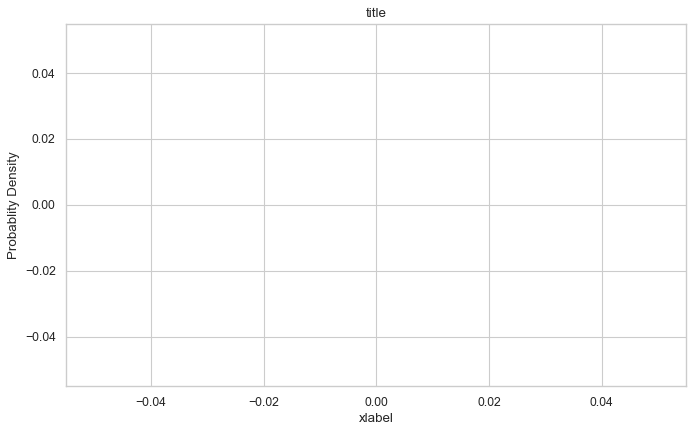

In [107]:
DF.KDE_dist_plotter(series=df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS)

In [68]:
sbs = scen1_tbm[['Id', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC',
'VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA', 
'VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP', 
'VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST',
'VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU']]


In [69]:
sbs = sbs.set_index('Id')

In [70]:
sbs

,VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC,VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP,VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA,VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG,VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU
Id,,,,,,,,,,,,,,,,,
11157450,5.001000,5.649000,32.676998,40.021999,44.493999,7.145,6.761,0.0,4.187000,35.536999,0.0,1.047,5.475,5.511,5.554,0.0,2.478
11154639,5.230000,5.803000,12.017000,8.820000,37.959000,7.125,0.000,0.0,4.488000,13.419000,0.0,0.994,8.867,3.625,5.782,0.0,2.675
11154772,5.268000,5.908000,11.941000,8.959000,33.439999,7.197,0.000,0.0,4.282000,13.014000,0.0,1.011,8.839,3.654,5.752,0.0,2.680
11154774,5.229000,5.753000,28.875999,8.448000,6.864000,0.221,0.000,0.0,4.132000,13.120000,0.0,1.015,8.864,3.671,5.754,0.0,2.638
11154775,5.253000,5.807000,11.947000,8.782000,15.367000,7.174,0.000,0.0,4.187000,13.276000,0.0,1.004,8.831,3.681,5.760,0.0,2.676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974198,4.733000,5.427000,12.065000,7.678000,27.099001,7.148,6.711,0.0,4.057000,30.653000,0.0,1.149,3.947,6.042,5.212,0.0,1.939
11974199,4.843000,5.401000,12.118000,7.609000,48.118999,7.098,6.548,0.0,4.042000,32.723999,0.0,1.144,3.835,6.083,5.164,0.0,1.958
11974367,141.533997,11.306000,46.032001,7.257000,6.773000,0.324,6.537,0.0,3.992000,48.141998,0.0,1.108,3.937,6.055,5.232,0.0,1.987


In [71]:
z_scores = stats.zscore(sbs)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = sbs[filtered_entries]

In [72]:
new_df
# Columns are only Cycle times for non-PAAP steps 

,VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC,VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP,VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA,VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG,VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU
Id,,,,,,,,,,,,,,,,,
11157450,5.001,5.649000,32.676998,40.021999,44.493999,7.145,6.761,0.0,4.187000,35.536999,0.0,1.047,5.475,5.511,5.554,0.0,2.478
11154639,5.230,5.803000,12.017000,8.820000,37.959000,7.125,0.000,0.0,4.488000,13.419000,0.0,0.994,8.867,3.625,5.782,0.0,2.675
11154772,5.268,5.908000,11.941000,8.959000,33.439999,7.197,0.000,0.0,4.282000,13.014000,0.0,1.011,8.839,3.654,5.752,0.0,2.680
11154774,5.229,5.753000,28.875999,8.448000,6.864000,0.221,0.000,0.0,4.132000,13.120000,0.0,1.015,8.864,3.671,5.754,0.0,2.638
11154775,5.253,5.807000,11.947000,8.782000,15.367000,7.174,0.000,0.0,4.187000,13.276000,0.0,1.004,8.831,3.681,5.760,0.0,2.676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294203,4.887,5.481000,44.456001,8.253000,6.801000,0.321,0.000,0.0,24.641001,5.539000,0.0,1.102,3.912,6.014,5.556,0.0,1.947
11974198,4.733,5.427000,12.065000,7.678000,27.099001,7.148,6.711,0.0,4.057000,30.653000,0.0,1.149,3.947,6.042,5.212,0.0,1.939
11974199,4.843,5.401000,12.118000,7.609000,48.118999,7.098,6.548,0.0,4.042000,32.723999,0.0,1.144,3.835,6.083,5.164,0.0,1.958


In [67]:
abs_z_scores

,VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP,VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC,VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP,VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS,VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT,VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA,VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP,VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG,VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU
Id,,,,,,,,,,,,,,,,,,
11157450,0.124041,0.164932,0.358443,1.150145,0.063816,0.691391,0.278905,NaN,0.02073,0.159304,0.462501,0.155118,0.170803,0.014805,0.231691,0.046074,0.193032,0.361962
11154639,0.111064,0.158415,0.206905,0.146237,0.088713,0.685446,0.127192,NaN,0.02073,0.150098,0.082814,0.155118,0.220876,0.902484,0.700889,0.006380,0.193032,0.661893
11154772,0.108911,0.153972,0.208985,0.140462,0.105929,0.706848,0.127192,NaN,0.02073,0.156398,0.092799,0.155118,0.204815,0.894912,0.686549,0.000522,0.193032,0.669505
11154774,0.111121,0.160531,0.254431,0.161693,0.207175,1.366774,0.127192,NaN,0.02073,0.160986,0.090186,0.155118,0.201036,0.901673,0.678143,0.000061,0.193032,0.605561
11154775,0.109761,0.158246,0.208821,0.147816,0.174781,0.700012,0.127192,NaN,0.02073,0.159304,0.086340,0.155118,0.211429,0.892749,0.673198,0.001319,0.193032,0.663415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974198,0.139227,0.174325,0.205592,0.193685,0.130086,0.692283,0.275902,NaN,0.02073,0.163280,0.342087,0.155118,0.074436,0.428017,0.494258,0.124754,0.193032,0.458658
11974199,0.132994,0.175425,0.204142,0.196552,0.050006,0.677421,0.266111,NaN,0.02073,0.163739,0.393147,0.155118,0.079160,0.458305,0.514531,0.135797,0.193032,0.429731
11974367,7.612872,0.074438,0.723895,0.211177,0.207521,1.336157,0.265451,NaN,0.02073,0.165268,0.773275,0.155118,0.113172,0.430722,0.500686,0.120153,0.193032,0.385579


In [77]:
scen1_tbm = scen1_tbm[scen1_tbm.Id.isin(new_df.index.to_list())]

In [78]:
scen1_tbm

,start_time_x,ProducedOn_x,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP_x,cycle_time_s_x,RecipeName_x,Id,key,Type,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,start_time_y,cycle_time_s_y,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-02 11:04:03,2022-02-02 11:06:32,68,2022-02-02 11:05:25.616738400,74.818001,149,GG225517HYPNW,11157450,96102TBM_1,OM,...,5.511,5.554,0.0,2.478,2022-02-02 11:04:03,149,276.355996,66.549999,2022-02-02 11:05:25.450001359,2022-02-02 11:04:10.632000566
1,2022-02-02 06:13:33,2022-02-02 06:16:52,150,2022-02-02 06:16:12.195732000,153.955994,199,GG236517HTRNH,11154639,96102TBM_1,OM,...,3.625,5.782,0.0,2.675,2022-02-02 06:13:33,199,270.759992,39.849999,2022-02-02 06:16:12.150000751,2022-02-02 06:13:38.194007099
2,2022-02-02 06:22:23,2022-02-02 06:23:49,38,2022-02-02 06:23:11.253159400,42.612000,86,GG236517HTRNH,11154772,96102TBM_1,OM,...,3.654,5.752,0.0,2.680,2022-02-02 06:22:23,86,154.556998,39.232000,2022-02-02 06:23:09.768000245,2022-02-02 06:22:27.156000733
3,2022-02-02 06:25:15,2022-02-02 06:26:27,23,2022-02-02 06:25:49.731527600,27.575001,72,GG236517HTRNH,11154774,96102TBM_1,OM,...,3.671,5.754,0.0,2.638,2022-02-02 06:25:15,72,122.160000,39.194000,2022-02-02 06:25:47.805999637,2022-02-02 06:25:20.230998874
4,2022-02-02 06:26:27,2022-02-02 06:28:02,35,2022-02-02 06:27:23.642323600,39.584000,95,GG236517HTRNH,11154775,96102TBM_1,OM,...,3.681,5.760,0.0,2.676,2022-02-02 06:26:27,95,133.328999,39.415000,2022-02-02 06:27:22.584999561,2022-02-02 06:26:43.000999927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,2022-05-03 14:58:33,2022-05-03 14:59:44,14,2022-05-03 14:58:58.370531200,17.600000,71,GG224517QPRXY,12294203,96102TBM_1,OM,...,6.014,5.556,0.0,1.947,2022-05-03 14:58:33,71,136.510003,48.711001,2022-05-03 14:58:55.288999081,2022-05-03 14:58:37.688998700
2328,2022-04-05 12:31:09,2022-04-05 12:32:35,16,2022-04-05 12:31:36.272789700,21.445000,86,GG214517ULAWA,11974198,96102TBM_1,OM,...,6.042,5.212,0.0,1.939,2022-04-05 12:31:09,86,145.305000,59.710000,2022-04-05 12:31:35.290000200,2022-04-05 12:31:13.845000505
2329,2022-04-05 12:32:35,2022-04-05 12:33:53,9,2022-04-05 12:32:53.897394500,12.657000,78,GG214517ULAWA,11974199,96102TBM_1,OM,...,6.083,5.164,0.0,1.958,2022-04-05 12:32:35,78,159.342998,61.497999,2022-04-05 12:32:51.502001047,2022-04-05 12:32:38.845001459
2331,2022-04-01 19:19:21,2022-04-01 19:20:58,59,2022-04-01 19:20:29.901888100,63.377998,97,GG224517ULAXY,11919967,96102TBM_1,OM,...,6.120,5.600,0.0,1.933,2022-04-01 19:19:21,97,215.415001,28.054000,2022-04-01 19:20:29.946000338,2022-04-01 19:19:26.568001986


1. Scenario 1 i.e. Alarm Duration < PAAP Times
2. All other steps other than PAAP are NOT outliers


In [110]:
scen1_tbm.sample(3)['']

,start_time_x,ProducedOn_x,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP_x,cycle_time_s_x,RecipeName_x,Id,key,Type,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,start_time_y,cycle_time_s_y,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
686,2022-02-09 02:24:19,2022-02-09 02:25:09,14,2022-02-09 02:24:42.486563200,17.298000,50,GG205017QPRXY,11233107,96102TBM_1,OM,...,3.496,5.226,0.0,1.979,2022-02-09 02:24:19,50,98.825999,28.182,2022-02-09 02:24:40.818000078,2022-02-09 02:24:23.519999742
1992,2022-04-21 15:05:51,2022-04-21 15:07:13,23,2022-04-21 15:06:23.483240200,27.507999,82,GG214517ULAWA,12141212,96102TBM_1,OM,...,6.188,5.319,0.0,1.944,2022-04-21 15:05:51,82,235.260000,49.858,2022-04-21 15:06:23.141999602,2022-04-21 15:05:55.634000182
2287,2022-04-05 12:28:55,2022-04-05 12:30:05,2,2022-04-05 12:29:07.277099900,6.493000,70,GG214517ULAWA,11974196,96102TBM_1,OM,...,6.131,5.068,0.0,1.973,2022-04-05 12:28:55,70,160.798002,58.965,2022-04-05 12:29:06.034999728,2022-04-05 12:28:59.541999697


In [79]:
df_tbm

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.480,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730
1,2022-02-01 06:04:28,TBM 1,1347469,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:04:28,0015600677,GG224517HYPXY,...,5.667,0.0,2.480,11141586,2022-02-01 06:03:43,45,137.105000,36.230000,2022-02-01 06:03:51.770000100,2022-02-01 06:03:47.783000111
2,2022-02-01 06:05:33,TBM 1,1347470,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:05:33,0015600678,GG224517HYPXY,...,5.654,0.0,2.397,11141588,2022-02-01 06:04:28,65,92.177000,43.610000,2022-02-01 06:04:49.389999986,2022-02-01 06:04:45.452999950
3,2022-02-01 06:06:24,TBM 1,1347471,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:06:24,0015600679,GG224517HYPXY,...,5.572,0.0,2.448,11141590,2022-02-01 06:05:33,51,102.747001,34.745000,2022-02-01 06:05:49.255000234,2022-02-01 06:05:45.262000203
4,2022-02-01 06:07:52,TBM 1,1347472,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:07:52,0015600680,GG224517HYPXY,...,5.718,0.0,2.468,11141591,2022-02-01 06:06:24,88,186.372003,79.013001,2022-02-01 06:06:32.986998677,2022-02-01 06:06:29.088998675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110579,2022-05-16 05:53:49,TBM 1,1458476,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:53:49,0016499089,GG215017ULAXY,...,5.394,0.0,1.917,12467918,2022-05-16 05:53:10,39,76.988000,30.845001,2022-05-16 05:53:18.154999495,2022-05-16 05:53:14.217999459
110580,2022-05-16 05:54:27,TBM 1,1458477,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:54:27,0016499090,GG215017ULAXY,...,5.436,0.0,1.919,12467919,2022-05-16 05:53:49,38,72.697999,30.192000,2022-05-16 05:53:56.807999969,2022-05-16 05:53:52.876000047
110581,2022-05-16 05:55:05,TBM 1,1458478,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:55:05,0016499091,GG215017ULAXY,...,5.481,0.0,1.917,12467920,2022-05-16 05:54:27,38,72.351000,30.302000,2022-05-16 05:54:34.698000312,2022-05-16 05:54:30.771000266
110582,2022-05-16 05:57:04,TBM 1,1458479,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:57:04,0016499092,GG215017ULAXY,...,5.469,0.0,1.944,12468000,2022-05-16 05:55:05,119,152.235999,110.093999,2022-05-16 05:55:13.906001449,2022-05-16 05:55:09.924001336


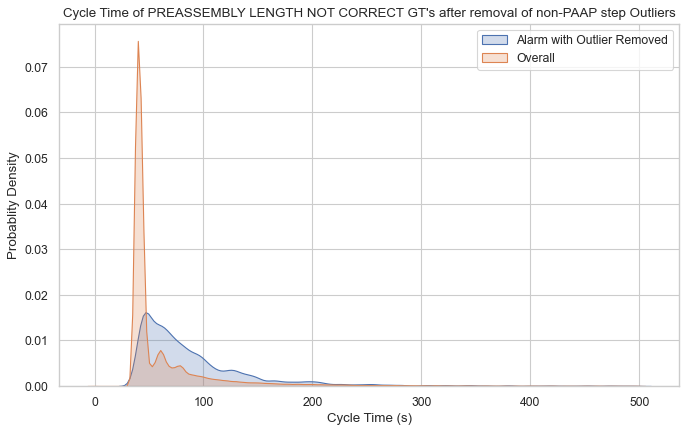

In [86]:
DF.KDE_dist_plotter_multiple(list_of_series = [scen1_tbm[scen1_tbm.cycle_time_s_x < 500].cycle_time_s_x, df_tbm[df_tbm.cycle_time_s < 500].cycle_time_s], label=['Alarm with Outlier Removed', 'Overall'], smoothness = .4, xlabel='Cycle Time (s)', title = 'Cycle Time of PREASSEMBLY LENGTH NOT CORRECT GT\'s after removal of non-PAAP step Outliers')

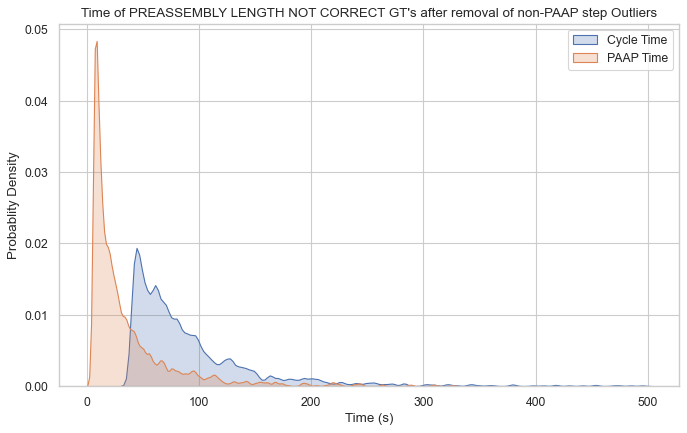

In [90]:
DF.KDE_dist_plotter_multiple(list_of_series = [scen1_tbm[scen1_tbm.cycle_time_s_x < 500].cycle_time_s_x, scen1_tbm[scen1_tbm.cycle_time_s_x < 500].VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP_x], label=['Cycle Time', 'PAAP Time'], smoothness = .2, xlabel='Time (s)', title = 'Time of PREASSEMBLY LENGTH NOT CORRECT GT\'s after removal of non-PAAP step Outliers')

In [104]:
scen1_tbm[scen1_tbm.cycle_time_s_x < 500].cycle_time_s_x.to_list()

[149,
 199,
 86,
 72,
 95,
 185,
 62,
 62,
 128,
 116,
 119,
 57,
 64,
 73,
 80,
 55,
 40,
 85,
 206,
 169,
 146,
 195,
 64,
 45,
 49,
 61,
 45,
 93,
 143,
 92,
 140,
 56,
 44,
 68,
 121,
 52,
 248,
 48,
 95,
 122,
 119,
 101,
 47,
 81,
 193,
 82,
 124,
 130,
 164,
 85,
 49,
 122,
 107,
 104,
 139,
 86,
 93,
 49,
 120,
 55,
 52,
 70,
 49,
 56,
 54,
 78,
 97,
 70,
 53,
 52,
 41,
 50,
 69,
 101,
 56,
 71,
 50,
 45,
 76,
 40,
 103,
 44,
 180,
 113,
 43,
 50,
 144,
 106,
 127,
 46,
 50,
 55,
 155,
 117,
 66,
 44,
 100,
 140,
 81,
 495,
 265,
 485,
 105,
 118,
 125,
 151,
 107,
 93,
 64,
 41,
 143,
 151,
 81,
 131,
 41,
 75,
 71,
 55,
 65,
 48,
 46,
 60,
 75,
 45,
 59,
 138,
 43,
 111,
 62,
 161,
 42,
 99,
 112,
 75,
 68,
 102,
 46,
 54,
 49,
 42,
 208,
 103,
 175,
 85,
 42,
 84,
 43,
 61,
 73,
 184,
 54,
 88,
 41,
 39,
 169,
 52,
 42,
 41,
 91,
 69,
 98,
 79,
 250,
 78,
 106,
 41,
 52,
 90,
 190,
 46,
 63,
 124,
 107,
 58,
 45,
 42,
 119,
 59,
 50,
 127,
 59,
 79,
 53,
 54,
 96,
 64,
 210,

In [113]:
X = scen1[scen1.cycle_time_s < 500].VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.to_list()
Y = [a - b for a, b in zip(scen1[scen1.cycle_time_s < 500].cycle_time_s.to_list(), scen1[scen1.cycle_time_s < 500].VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.to_list())]

In [114]:
import plotly.express as px
fig = px.scatter(x=X, y=Y, title="PAAP time vs Remaining Cycle Time for GT\'s with Alarm and Non-PAAP step Outliers Removed")
fig.update_layout(
    xaxis_title="PAAP time (s)",
    yaxis_title="Remaining Cycle Time (s)"
)
fig.show()